# Technical Analysis Indicator Price Prediction
The goal of this project is to analyze the predictive power of the top 10 most popular TA indicators and see how well they do to predict price over a 30 day period. I am going to find the value of the indicators on day 1 (30 trading days ago) and then find the daily closing price for 30 days later and measure how well the indicator predicted the price.  

first we'll find the top 500 stocks by market cap from nasdaq and pull them into a dataframe


In [1]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df = pd.read_csv(csv_file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(5000)                                                                        
df_sorted.head()


  Symbol                                               Name Last Sale  \
0      A             Agilent Technologies Inc. Common Stock   $138.31   
1     AA                    Alcoa Corporation Common Stock     $34.50   
2   AACG   ATA Creativity Global American Depositary Shares   $0.5025   
3   AACT  Ares Acquisition Corporation II Class A Ordina...    $10.80   
4   AADI                  Aadi Bioscience Inc. Common Stock     $1.88   

   Net Change % Change    Market Cap        Country  IPO Year    Volume  \
0      1.0000   0.728%  3.974029e+10  United States    1999.0    887040   
1      1.9800   6.089%  8.912735e+09  United States    2016.0  10730428   
2     -0.0275  -5.189%  1.608006e+07          China    2008.0     25043   
3      0.0200   0.186%  0.000000e+00            NaN    2023.0     35074   
4      0.0800   4.444%  4.627589e+07  United States       NaN     81942   

        Sector                                          Industry  
0  Industrials  Biotechnology: Laboratory A

,Symbol,Name,Market Cap
15,AAPL,Apple Inc. Common Stock,3.288959e+12
4208,MSFT,Microsoft Corporation Common Stock,3.206167e+12
4559,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
2819,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
2820,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


In [2]:
# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


remove all stocks except common stocks

In [3]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]

# Display the filtered DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
6,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [7]:
# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1

# Display the first few rows of the updated DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
5,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


below are the 10 technical indicators we are going to use for this project.
1. Relative Strength Index (RSI)
2. Moving Average Convergence Divergence (MACD)
3. Stochastic Oscillator
4. Simple Moving Average (SMA)
5. Exponential Moving Average (EMA)
6. Volume Weighted Average Price (VWAP)
7. Bollinger Bands
8. Average True Range (ATR)
9. Fibonacci Retracement 

In [ ]:
# There is a CSV file I have provided so this code does not need to be run again
# Computationally intensive

import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Function to download stock data for a single stock
def download_stock_data(ticker):
    try:
        data = yf.download(ticker, start="2022-02-10", end="2025-02-10", interval="1d")[['Close', 'High', 'Low', 'Volume']]
        if data.empty:
            print(f"Warning: No data found for {ticker} (possibly due to non-trading days like weekends or holidays)")
            return None  # Return None if the data is empty
        return data
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None  # Return None if there is any error (e.g., stock not found)

# List of tickers from your df_filtered dataframe
tickers = df_filtered['Symbol'].tolist()

# Batch size for processing tickers in chunks
batch_size = 100

# Create a function to download data for a batch of tickers in parallel
def download_batch(batch_tickers):
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(download_stock_data, batch_tickers))
    # Remove None values from the results
    return [result for result in results if result is not None]

# Loop through the tickers in batches
for i in range(0, len(tickers), batch_size):
    batch_tickers = tickers[i:i + batch_size]
    results = download_batch(batch_tickers)

    if results:  # Check if results are not empty
        # Combine all individual stock data into a single dataframe
        df_batch = pd.concat(results, keys=batch_tickers)

        # Save the data to CSV for the current batch
        df_batch.to_csv(f'/content/drive/MyDrive/stock_data_yahoo_{i // batch_size}.csv')
        print(f"Downloaded batch {i // batch_size} and saved to CSV")
    else:
        print(f"Batch {i // batch_size} has no data. Skipping...")
        # Optionally, log the tickers that failed for this batch
        print(f"Failed tickers in batch {i // batch_size}: {batch_tickers}")


In [10]:
import pandas as pd

# Initialize an empty list to hold DataFrames
df_list = []

# List of specific file indices
file_indices = [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 45, 44, 26, 18, 46]

# Loop through the specific CSV file indices
for i in file_indices:
    # Construct the file path for each batch
    csv_file_path = f'/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_data_yahoo_{i}.csv'

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Rename 'Price' column to 'Symbol'
    df = df.rename(columns={'Price': 'Symbol'})

    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames in the list along the rows (axis=0)
df_all = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the merged DataFrame
df_all.head()


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/562544689.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/562544689.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/5625446

,Symbol,Unnamed: 1,Close,Close.1,High,High.1,Low,Low.1,Volume,Volume.1,...,Low.21,Volume.21,Close.22,High.22,Low.22,Volume.22,Close.23,High.23,Low.23,Volume.23
0,Ticker,NaN,CCCS,POST,CCCS,POST,CCCS,POST,CCCS,POST,...,WTS,WTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,69.12957763671875,10.729999542236328,70.2225112915039,10.199999809265137,68.92015838623047,1037700.0,642524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-11,10.09000015258789,69.76439666748047,10.489999771118164,70.5235595703125,10.020000457763672,68.95942687988281,480300.0,492169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-14,10.220000267028809,71.02094268798828,10.460000038146973,71.27617645263672,9.970000267028809,69.64659881591797,724400.0,672473.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Get a list of distinct tickers in the 'Symbol' column
distinct_symbols = df_all['Symbol'].unique()

# Count the number of distinct symbols
num_distinct_symbols = len(distinct_symbols)

# Print the result
print(f"Number of distinct symbols: {num_distinct_symbols}")

# Optionally, print the list of distinct symbols (first 10 for brevity)
print(f"List of distinct symbols (first 10): {distinct_symbols[:10]}")


Number of distinct symbols: 1792
List of distinct symbols (first 10): ['Ticker' nan 'AAPL' 'MSFT' 'NVDA' 'GOOGL' 'AMZN' 'META' 'BRK/A' 'BRK/B']


In [12]:
# Get the list of unique symbols from df_all and df_filtered
unique_symbols_all = df_all['Symbol'].unique()
unique_symbols_filtered = df_filtered['Symbol'].unique()

# Find the symbols that are in df_all but not in df_filtered, ensuring all items are strings
symbols_not_in_filtered = [str(symbol) for symbol in unique_symbols_all if str(symbol) not in map(str, unique_symbols_filtered)]

# Print the list of symbols that are not in df_filtered
print('\n'.join(symbols_not_in_filtered))


Ticker
nan


In [13]:
import numpy as np

# Convert 'nan' strings or any NaN-like values to actual np.nan
df_all['Symbol'] = df_all['Symbol'].apply(lambda x: np.nan if (isinstance(x, str) and x.lower() == 'nan') or pd.isna(x) else x)

# Drop rows where the 'Symbol' column contains NaN values
df_all_cleaned = df_all.dropna(subset=['Symbol'])

# Verify the result by checking the first few rows
df_all_cleaned.head()


,Symbol,Unnamed: 1,Close,Close.1,High,High.1,Low,Low.1,Volume,Volume.1,...,Low.21,Volume.21,Close.22,High.22,Low.22,Volume.22,Close.23,High.23,Low.23,Volume.23
0,Ticker,NaN,CCCS,POST,CCCS,POST,CCCS,POST,CCCS,POST,...,WTS,WTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,69.12957763671875,10.729999542236328,70.2225112915039,10.199999809265137,68.92015838623047,1037700.0,642524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-11,10.09000015258789,69.76439666748047,10.489999771118164,70.5235595703125,10.020000457763672,68.95942687988281,480300.0,492169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-14,10.220000267028809,71.02094268798828,10.460000038146973,71.27617645263672,9.970000267028809,69.64659881591797,724400.0,672473.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,AAPL,2022-02-15,10.5600004196167,71.5575942993164,10.569999694824219,72.25785064697266,10.220000267028809,70.99476623535156,758700.0,380319.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# This will ensure that if any main column (Close, High, Low, or Volume)
# has missing values, they will be filled with the corresponding values
# from the suffixed columns (e.g., Close.1, Close.2, etc.), and once done,
# the suffixed columns will be removed from the DataFrame.

import re

# List of main columns
main_columns = ['Close', 'High', 'Low', 'Volume']

# Iterate over the main columns to check and replace NaN values with corresponding suffixed columns
for col in main_columns:
    # Look for columns with numeric suffixes like .1, .2, .3, ..., .23
    suffix_columns = [col + '.' + str(i) for i in range(1, 24)]  # Create the list of possible suffixes

    # For each suffix column, if it exists, fill NaN in the main column with its values
    for suffix_col in suffix_columns:
        if suffix_col in df_all.columns:
            df_all[col] = df_all[col].fillna(df_all[suffix_col])

    # After filling NaN values from the suffixed columns, drop the suffixed columns
    df_all_cleaned = df_all.drop(columns=suffix_columns)

# Verify the changes
print(df_all_cleaned.head())


   Symbol  Unnamed: 1               Close            Close.1  \
0  Ticker         NaN                CCCS               POST   
1     NaN        Date                 NaN                NaN   
2    AAPL  2022-02-10  10.520000457763672  69.12957763671875   
3    AAPL  2022-02-11   10.09000015258789  69.76439666748047   
4    AAPL  2022-02-14  10.220000267028809  71.02094268798828   

                 High             High.1                 Low  \
0                CCCS               POST                CCCS   
1                 NaN                NaN                 NaN   
2  10.729999542236328   70.2225112915039  10.199999809265137   
3  10.489999771118164   70.5235595703125  10.020000457763672   
4  10.460000038146973  71.27617645263672   9.970000267028809   

               Low.1     Volume Close.2  ... Low.20 Close.21 High.21 Low.21  \
0               POST       CCCS    LOAR  ...    KBH      WTS     WTS    WTS   
1                NaN        NaN     NaN  ...    NaN      NaN     NaN    

In [15]:
df_all_cleaned.columns

Index(['Symbol', 'Unnamed: 1', 'Close', 'Close.1', 'High', 'High.1', 'Low',
       'Low.1', 'Volume', 'Close.2', 'High.2', 'Low.2', 'Close.3', 'High.3',
       'Low.3', 'Close.4', 'High.4', 'Low.4', 'Close.5', 'High.5', 'Low.5',
       'Close.6', 'High.6', 'Low.6', 'Close.7', 'High.7', 'Low.7', 'Close.8',
       'High.8', 'Low.8', 'Close.9', 'High.9', 'Low.9', 'Close.10', 'High.10',
       'Low.10', 'Close.11', 'High.11', 'Low.11', 'Close.12', 'High.12',
       'Low.12', 'Close.13', 'High.13', 'Low.13', 'Close.14', 'High.14',
       'Low.14', 'Close.15', 'High.15', 'Low.15', 'Close.16', 'High.16',
       'Low.16', 'Close.17', 'High.17', 'Low.17', 'Close.18', 'High.18',
       'Low.18', 'Close.19', 'High.19', 'Low.19', 'Close.20', 'High.20',
       'Low.20', 'Close.21', 'High.21', 'Low.21', 'Close.22', 'High.22',
       'Low.22', 'Close.23', 'High.23', 'Low.23'],
      dtype='object')

In [16]:
# List of columns you want to keep
columns_to_keep = ['Symbol', 'Unnamed: 1', 'Close', 'High', 'Low', 'Volume']

# Select only the columns you want to keep and drop the others
df_all_cleaned = df_all_cleaned[columns_to_keep]

# Verify the result by checking the first few rows
df_all_cleaned.head()


,Symbol,Unnamed: 1,Close,High,Low,Volume
0,Ticker,NaN,CCCS,CCCS,CCCS,CCCS
1,NaN,Date,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0
3,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0
4,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0


In [17]:
# Rename the 'Unnamed: 1' column to 'Date'
df_all_cleaned = df_all_cleaned.rename(columns={'Unnamed: 1': 'Date'})

# Verify the change by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume
0,Ticker,NaN,CCCS,CCCS,CCCS,CCCS
1,NaN,Date,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0
3,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0
4,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0


In [18]:
# Drop rows with index 0 and 1
df_all_cleaned = df_all_cleaned.drop([0, 1])

# Reset the index
df_all_cleaned = df_all_cleaned.reset_index(drop=True)

# Verify the changes by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume
0,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0
1,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0
2,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0
3,AAPL,2022-02-15,10.5600004196167,10.569999694824219,10.220000267028809,758700.0
4,AAPL,2022-02-16,10.4399995803833,10.550000190734863,10.390000343322754,685200.0


In [20]:
# Check for non-numeric values in the 'Close' column
non_numeric_values = df_all_cleaned[~df_all_cleaned['Close'].apply(pd.to_numeric, errors='coerce').notna()]
print(non_numeric_values[['Date', 'Symbol', 'Close']].head())

        Date  Symbol Close
57472    NaN  Ticker  MASI
57473   Date     NaN   NaN
109293   NaN  Ticker  BILL
109294  Date     NaN   NaN
169643   NaN  Ticker   NVO


In [21]:
df_all_cleaned = df_all_cleaned[pd.to_numeric(df_all_cleaned['Close'], errors='coerce').notna()]


In [22]:
# Simple Moving Average
# 5 Day SMA, 20 Day SMA, and 50 Day SMA

# Group by 'Symbol' and then apply rolling averages within each group
df_all_cleaned['SMA_5'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df_all_cleaned['SMA_20'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=20, min_periods=1).mean().reset_index(level=0, drop=True)
df_all_cleaned['SMA_50'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=50, min_periods=1).mean().reset_index(level=0, drop=True)

# Verify the results by checking the first few rows
df_all_cleaned.head(10)



,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50
0,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000
1,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000
2,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667
3,AAPL,2022-02-15,10.5600004196167,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500
4,AAPL,2022-02-16,10.4399995803833,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000
5,AAPL,2022-02-17,10.1899995803833,10.399999618530273,10.109999656677246,609500.0,10.300000,10.336667,10.336667
6,AAPL,2022-02-18,10.09000015258789,10.3100004196167,10.069999694824219,623100.0,10.300000,10.301429,10.301429
7,AAPL,2022-02-22,10.149999618530273,10.279999732971191,9.920000076293945,733000.0,10.286000,10.282500,10.282500
8,AAPL,2022-02-23,9.930000305175781,10.329999923706055,9.930000305175781,625600.0,10.160000,10.243333,10.243333
9,AAPL,2022-02-24,10.460000038146973,10.479999542236328,9.680000305175781,1043800.0,10.164000,10.265000,10.265000


In [23]:
# Exponential Moving Average

# Exponential Moving Average (EMA)
# 5 Day EMA, 20 Day EMA, and 50 Day EMA

# Group by 'Symbol' and then apply ewm (Exponential Moving Average) within each group
df_all_cleaned['EMA_5'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=5, adjust=False).mean().reset_index(level=0, drop=True)
df_all_cleaned['EMA_20'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=20, adjust=False).mean().reset_index(level=0, drop=True)
df_all_cleaned['EMA_50'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=50, adjust=False).mean().reset_index(level=0, drop=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50
0,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000
1,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138
2,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034
3,AAPL,2022-02-15,10.5600004196167,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700
4,AAPL,2022-02-16,10.4399995803833,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555


In [25]:
df_all_cleaned['Close'] = pd.to_numeric(df_all_cleaned['Close'], errors='coerce')


In [26]:
# RSI


# Define a function to calculate RSI
def calculate_rsi(df, window=14):
    # Calculate price changes
    delta = df['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Apply the function to the dataframe to calculate RSI
df_all_cleaned['RSI'] = calculate_rsi(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50,RSI
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,NaN
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138,NaN
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034,NaN
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700,NaN
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555,NaN


In [27]:
# MACD

# Calculate the 12-day EMA (Fast EMA) and reset the index
df_all_cleaned['EMA_12_MACD'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=12, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the 26-day EMA (Slow EMA) and reset the index
df_all_cleaned['EMA_26_MACD'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=26, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the MACD (12-day EMA - 26-day EMA)
df_all_cleaned['MACD'] = df_all_cleaned['EMA_12_MACD'] - df_all_cleaned['EMA_26_MACD']

# Calculate the Signal Line (9-day EMA of the MACD) and reset the index
df_all_cleaned['Signal_Line'] = df_all_cleaned.groupby('Symbol')['MACD'].ewm(span=9, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the MACD Histogram (MACD - Signal Line)
df_all_cleaned['MACD_Histogram'] = df_all_cleaned['MACD'] - df_all_cleaned['Signal_Line']

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50,RSI,EMA_12_MACD,EMA_26_MACD,MACD,Signal_Line,MACD_Histogram
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,NaN,10.520000,10.520000,0.000000,0.000000,0.000000
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138,NaN,10.453847,10.488149,-0.034302,-0.006860,-0.027442
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034,NaN,10.417870,10.468286,-0.050416,-0.015571,-0.034844
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700,NaN,10.439736,10.475079,-0.035343,-0.019526,-0.015817
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555,NaN,10.439777,10.472481,-0.032704,-0.022161,-0.010543


In [28]:
# stochastic oscillator
# Calculate the Stochastic Oscillator (%K)
df_all_cleaned['Stoch_Lowest_Low_14'] = df_all_cleaned.groupby('Symbol')['Low'].rolling(window=14).min().reset_index(level=0, drop=True)
df_all_cleaned['Stoch_Highest_High_14'] = df_all_cleaned.groupby('Symbol')['High'].rolling(window=14).max().reset_index(level=0, drop=True)

df_all_cleaned['%K'] = ((df_all_cleaned['Close'] - df_all_cleaned['Stoch_Lowest_Low_14']) / (df_all_cleaned['Stoch_Highest_High_14'] - df_all_cleaned['Stoch_Lowest_Low_14'])) * 100

# Calculate the %D (3-day Simple Moving Average of %K)
df_all_cleaned['%D'] = df_all_cleaned.groupby('Symbol')['%K'].rolling(window=3).mean().reset_index(level=0, drop=True)

# Drop intermediate columns if you don't need them
df_all_cleaned.drop(columns=['Stoch_Lowest_Low_14', 'Stoch_Highest_High_14'], inplace=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50,RSI,EMA_12_MACD,EMA_26_MACD,MACD,Signal_Line,MACD_Histogram,%K,%D
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,NaN,10.520000,10.520000,0.000000,0.000000,0.000000,NaN,NaN
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138,NaN,10.453847,10.488149,-0.034302,-0.006860,-0.027442,NaN,NaN
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034,NaN,10.417870,10.468286,-0.050416,-0.015571,-0.034844,NaN,NaN
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700,NaN,10.439736,10.475079,-0.035343,-0.019526,-0.015817,NaN,NaN
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555,NaN,10.439777,10.472481,-0.032704,-0.022161,-0.010543,NaN,NaN


In [29]:
# VWAP

# Calculate Volume Weighted Average Price (VWAP) per symbol
def calculate_vwap(df):
    # Ensure 'Close' and 'Volume' are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Group by 'Symbol' and calculate VWAP for each symbol
    df['Cumulative_Price_Volume'] = df.groupby('Symbol').apply(
        lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, drop=True)

    df['Cumulative_Volume'] = df.groupby('Symbol').apply(
        lambda x: x['Volume'].cumsum()).reset_index(level=0, drop=True)

    # Calculate VWAP as the ratio of cumulative sums for each group (symbol)
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

    return df

# Apply the function to calculate VWAP
df_all_cleaned = calculate_vwap(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,EMA_12_MACD,EMA_26_MACD,MACD,Signal_Line,MACD_Histogram,%K,%D,Cumulative_Price_Volume,Cumulative_Volume,VWAP
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.520000,10.520000,0.000000,0.000000,0.000000,NaN,NaN,1.091660e+07,1037700.0,10.520000
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.453847,10.488149,-0.034302,-0.006860,-0.027442,NaN,NaN,1.576283e+07,1518000.0,10.383947
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.417870,10.468286,-0.050416,-0.015571,-0.034844,NaN,NaN,2.316620e+07,2242400.0,10.330985
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.439736,10.475079,-0.035343,-0.019526,-0.015817,NaN,NaN,3.117807e+07,3001100.0,10.388881
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.439777,10.472481,-0.032704,-0.022161,-0.010543,NaN,NaN,3.833156e+07,3686300.0,10.398383


In [30]:
# Calculate Bollinger Bands per symbol
def calculate_bollinger_bands(df, window=20):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Calculate the rolling mean (Middle Band) and rolling standard deviation
    df['Middle_Band'] = df.groupby('Symbol')['Close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Std_Dev'] = df.groupby('Symbol')['Close'].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)

    # Calculate the Upper and Lower Bands
    df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * 2)

    return df

# Apply the function to calculate Bollinger Bands
df_all_cleaned = calculate_bollinger_bands(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,MACD_Histogram,%K,%D,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Middle_Band,Std_Dev,Upper_Band,Lower_Band
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,...,0.000000,NaN,NaN,1.091660e+07,1037700.0,10.520000,10.520000,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,...,-0.027442,NaN,NaN,1.576283e+07,1518000.0,10.383947,10.305000,0.304056,10.913113,9.696888
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,...,-0.034844,NaN,NaN,2.316620e+07,2242400.0,10.330985,10.276667,0.220530,10.717727,9.835607
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,...,-0.015817,NaN,NaN,3.117807e+07,3001100.0,10.388881,10.347500,0.229111,10.805722,9.889279
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,...,-0.010543,NaN,NaN,3.833156e+07,3686300.0,10.398383,10.366000,0.202682,10.771364,9.960636


In [31]:
# Average True Range (ATR)

# Function to calculate True Range (TR)
def calculate_true_range(df):
    # Convert relevant columns to numeric (if not already numeric)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Ensure previous close is calculated per stock symbol to prevent cross-stock contamination
    df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ATR_High_Low'] = df['High'] - df['Low']  # High - Low
    df['ATR_High_Close'] = (df['High'] - df['ATR_Prev_Close']).abs()  # High - Prev Close
    df['ATR_Low_Close'] = (df['Low'] - df['ATR_Prev_Close']).abs()  # Low - Prev Close

    # True Range is the max of the three
    df['ATR_True_Range'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)

    return df

# Function to calculate Average True Range (ATR)
def calculate_atr(df, window=14):
    # Apply the True Range calculation
    df = calculate_true_range(df)

    # Compute ATR within each stock symbol
    df['ATR'] = df.groupby('Symbol')['ATR_True_Range'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    return df

# Apply the function to calculate ATR
df_all_cleaned = calculate_atr(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,Middle_Band,Std_Dev,Upper_Band,Lower_Band,ATR_Prev_Close,ATR_High_Low,ATR_High_Close,ATR_Low_Close,ATR_True_Range,ATR
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.520000,NaN,NaN,NaN,NaN,0.530000,NaN,NaN,0.530000,0.530000
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.305000,0.304056,10.913113,9.696888,10.52,0.469999,0.030001,0.50,0.500000,0.515000
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.276667,0.220530,10.717727,9.835607,10.09,0.490000,0.370000,0.12,0.490000,0.506667
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.347500,0.229111,10.805722,9.889279,10.22,0.349999,0.349999,0.00,0.349999,0.467500
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.366000,0.202682,10.771364,9.960636,10.56,0.160000,0.010000,0.17,0.170000,0.408000


In [32]:
# Fibonacci Retracement levels

import numpy as np
import pandas as pd

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_30_day(df, window=30):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_30_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_30_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'30_day_Fib_{int(level*100)}'] = stock_df['Fib_30_High_Max'] - (level * (stock_df['Fib_30_High_Max'] - stock_df['Fib_30_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_10_day(df, window=10):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_10_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_10_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'10_day_Fib_{int(level*100)}'] = stock_df['Fib_10_High_Max'] - (level * (stock_df['Fib_10_High_Max'] - stock_df['Fib_10_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df


# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_5_day(df, window=5):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_5_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_5_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'5_day-Fib_{int(level*100)}'] = stock_df['Fib_5_High_Max'] - (level * (stock_df['Fib_5_High_Max'] - stock_df['Fib_5_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df

# Apply Fibonacci Retracement calculation to the dataframe
df_all_cleaned = calculate_fibonacci_retracement_30_day(df_all_cleaned, window=30)
df_all_cleaned = calculate_fibonacci_retracement_10_day(df_all_cleaned, window=10)
df_all_cleaned = calculate_fibonacci_retracement_5_day(df_all_cleaned, window=5)

# Display the first few rows to verify results
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,10_day_Fib_50,10_day_Fib_61,10_day_Fib_100,Fib_5_High_Max,Fib_5_Low_Min,5_day-Fib_23,5_day-Fib_38,5_day-Fib_50,5_day-Fib_61,5_day-Fib_100
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.465,10.40246,10.20,10.73,10.20,10.60492,10.52754,10.465,10.40246,10.20
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.375,10.29122,10.02,10.73,10.02,10.56244,10.45878,10.375,10.29122,10.02
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97


In [33]:
# Save DataFrame as CSV file for easy access
df_all_cleaned.to_csv('/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_ta_data.csv', index=False)

In [34]:
# Specify the file path to your CSV in Google Drive
csv_file_path = '/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_ta_data.csv'

# Load the CSV file into a DataFrame
df_all_cleaned = pd.read_csv(csv_file_path)

# Inspect the DataFrame
df_all_cleaned.head()

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,10_day_Fib_50,10_day_Fib_61,10_day_Fib_100,Fib_5_High_Max,Fib_5_Low_Min,5_day-Fib_23,5_day-Fib_38,5_day-Fib_50,5_day-Fib_61,5_day-Fib_100
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.465,10.40246,10.20,10.73,10.20,10.60492,10.52754,10.465,10.40246,10.20
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.375,10.29122,10.02,10.73,10.02,10.56244,10.45878,10.375,10.29122,10.02
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97


In [35]:
df_stocks_price_ta =df_all_cleaned.copy()
df_stocks_price_ta.head()

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,10_day_Fib_50,10_day_Fib_61,10_day_Fib_100,Fib_5_High_Max,Fib_5_Low_Min,5_day-Fib_23,5_day-Fib_38,5_day-Fib_50,5_day-Fib_61,5_day-Fib_100
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.465,10.40246,10.20,10.73,10.20,10.60492,10.52754,10.465,10.40246,10.20
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.375,10.29122,10.02,10.73,10.02,10.56244,10.45878,10.375,10.29122,10.02
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97


In [36]:
# Create a new dataframe called 'df_stock_data_1_week' as a copy of 'df_stocks_price_ta'
df_stock_data_1_week = df_stocks_price_ta.copy()

# List of columns to create lags for (focusing on short-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_1_week[f'{col}_lag_{lag}'] = df_stock_data_1_week[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_1_week.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,SMA_5_lag_5,SMA_5_lag_7,EMA_5_lag_1,EMA_5_lag_3,EMA_5_lag_5,EMA_5_lag_7,Volume_lag_1,Volume_lag_3,Volume_lag_5,Volume_lag_7
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,NaN,NaN,10.520000,NaN,NaN,NaN,1037700.0,NaN,NaN,NaN
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,NaN,NaN,10.376667,NaN,NaN,NaN,480300.0,NaN,NaN,NaN
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,NaN,NaN,10.324445,10.520000,NaN,NaN,724400.0,1037700.0,NaN,NaN
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,NaN,NaN,10.402963,10.376667,NaN,NaN,758700.0,480300.0,NaN,NaN


In [37]:
print(df_stock_data_1_week['Date'].dtype)


object


In [38]:
df_stock_data_1_week['Date'] = pd.to_datetime(df_stock_data_1_week['Date'], errors='coerce')
print(df_stock_data_1_week['Date'].dtype)

datetime64[ns]


In [39]:
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# baseline model

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train = df_stock_data_train.dropna(subset=['Close_Target'])
df_stock_data_test = df_stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test.select_dtypes(include=[np.number]).columns

df_stock_data_train[numeric_cols_train] = df_stock_data_train[numeric_cols_train].fillna(df_stock_data_train[numeric_cols_train].median())
df_stock_data_test[numeric_cols_test] = df_stock_data_test[numeric_cols_test].fillna(df_stock_data_test[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train.shape}")
print(f"Testing data shape: {df_stock_data_test.shape}")

# Create X (features) and y (target) for training
X_train = df_stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = df_stock_data_train['Close_Target']

# Create X and y for testing
X_test = df_stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = df_stock_data_test['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Ensure there are samples in both training and testing sets
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week.fit(X_train, y_train)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred = model_baseline_1_week.predict(X_test)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/4133690100.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/4133690100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train shape: (867895, 67), y_train shape: (867895,)
X_test shape: (430180, 67), y_test shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9222.592316604241


In [40]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred` are your predictions for the test data and `y_test` are the true values for the test data

# Calculate performance metrics on unseen test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae = median_absolute_error(y_test, y_pred)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat = durbin_watson(y_test - y_pred)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE on unseen data: {mape:.2f}%')
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_baseline_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9222.592316604241
Mean Absolute Error on unseen data: 11.174428157067275
Root Mean Squared Error on unseen data: 96.03432884445145
R-squared on unseen data: 0.9582968719645971
Median Absolute Error on unseen data: 1.6202430725097656
Durbin-Watson Statistic on unseen data: 0.12107588672303043
MAPE on unseen data: 4.06%
Fib_10_Low_Min: 57.64%
Fib_30_High_Max: 16.90%
Low: 5.14%
High: 4.55%
5_day-Fib_61: 3.14%
Fib_30_Low_Min: 2.50%
5_day-Fib_38: 1.71%
EMA_5: 1.67%
5_day-Fib_50: 1.28%
Volume: 1.20%
30_day_Fib_50: 0.78%
SMA_5: 0.73%
SMA_50: 0.49%
EMA_50: 0.31%
30_day_Fib_61: 0.28%
Fib_5_Low_Min: 0.26%
Cumulative_Price_Volume: 0.21%
VWAP: 0.20%
ATR_Prev_Close: 0.16%
Std_Dev: 0.15%
5_day-Fib_23: 0.10%
10_day_Fib_23: 0.08%
Fib_5_High_Max: 0.07%
30_day_Fib_38: 0.06%
ATR_True_Range: 0.06%
Lower_Band: 0.06%
EMA_26_MACD: 0.04%
Cumulative_Volume: 0.04%
ATR: 0.02%
Fib_10_High_Max: 0.02%
SMA_20: 0.02%
30_day_Fib_23: 0.02%
Upper_Band: 0.02%
ATR_High_Low: 0.01%
Volume_

In [41]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%
# first we need to get a list of important feautres from our baseline
# model and create a new dataframe containing only those features
# Get feature importance as a dictionary
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_baseline_1_week.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the features names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)



Features with more than 1% contribution:
Fib_10_Low_Min: 57.64%
Fib_30_High_Max: 16.90%
Low: 5.14%
High: 4.55%
5_day-Fib_61: 3.14%
Fib_30_Low_Min: 2.50%
5_day-Fib_38: 1.71%
EMA_5: 1.67%
5_day-Fib_50: 1.28%
Volume: 1.20%
List of important features:
['Fib_10_Low_Min', 'Fib_30_High_Max', 'Low', 'High', '5_day-Fib_61', 'Fib_30_Low_Min', '5_day-Fib_38', 'EMA_5', '5_day-Fib_50', 'Volume']


In [42]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_10_Low_Min', 'Fib_30_High_Max',
                      'Low', 'High', '5_day-Fib_61', 'Fib_30_Low_Min', 'EMA_5',
                      '5_day-Fib_38', 'Volume', '5_day-Fib_50']
df_important_feat_1_week = df_stock_data_1_week[important_features]
df_important_feat_1_week.head()

,Symbol,Date,Close,Fib_10_Low_Min,Fib_30_High_Max,Low,High,5_day-Fib_61,Fib_30_Low_Min,EMA_5,5_day-Fib_38,Volume,5_day-Fib_50
171141,A,2022-02-10,50.058052,49.918547,51.174088,49.918547,51.174088,50.398164,49.918547,50.058052,50.694471,1889800.0,50.546317
171142,A,2022-02-11,47.580647,47.234290,51.174088,47.234290,49.028604,48.739293,47.234290,49.232250,49.669085,3747400.0,49.204189
171143,A,2022-02-14,47.210232,46.796529,51.174088,46.796529,47.460380,48.468756,46.796529,48.558244,49.501860,3157800.0,48.985308
171144,A,2022-02-15,48.759216,46.796529,51.174088,48.427291,49.153677,48.468756,46.796529,48.625235,49.501860,1900000.0,48.985308
171145,A,2022-02-16,49.629917,46.796529,51.174088,48.855427,49.716506,48.468756,46.796529,48.960129,49.501860,2010600.0,48.985308


In [43]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_1_week = df_important_feat_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train = df_important_feat_1_week[df_important_feat_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test = df_important_feat_1_week[df_important_feat_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train = df_stock_data_train.dropna(subset=['Close_Target'])
df_stock_data_test = df_stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test.select_dtypes(include=[np.number]).columns

df_stock_data_train[numeric_cols_train] = df_stock_data_train[numeric_cols_train].fillna(df_stock_data_train[numeric_cols_train].median())
df_stock_data_test[numeric_cols_test] = df_stock_data_test[numeric_cols_test].fillna(df_stock_data_test[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train.shape}")
print(f"Testing data shape: {df_stock_data_test.shape}")

# Create X (features) and y (target) for training
X_train = df_stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = df_stock_data_train['Close_Target']

# Create X and y for testing
X_test = df_stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = df_stock_data_test['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Ensure there are samples in both training and testing sets
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_update1_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_update1_1_week.fit(X_train, y_train)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred = model_update1_1_week.predict(X_test)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/115773503.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/115773503.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 14)
Testing data shape: (430180, 14)
X_train shape: (867895, 10), y_train shape: (867895,)
X_test shape: (430180, 10), y_test shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 29133.41088889282


In [44]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred` are your predictions for the test data and `y_test` are the true values for the test data

# Calculate performance metrics on unseen test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae = median_absolute_error(y_test, y_pred)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat = durbin_watson(y_test - y_pred)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE on unseen data: {mape:.2f}%')
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_update1_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 29133.41088889282
Mean Absolute Error on unseen data: 16.858962051733705
Root Mean Squared Error on unseen data: 170.68512204903163
R-squared on unseen data: 0.8682632471761647
Median Absolute Error on unseen data: 1.6140975952148438
Durbin-Watson Statistic on unseen data: 0.04397998041253925
MAPE on unseen data: 4.13%
Fib_10_Low_Min: 43.09%
Low: 22.04%
High: 16.96%
Fib_30_High_Max: 7.94%
Fib_30_Low_Min: 3.05%
Volume: 1.75%
EMA_5: 1.63%
5_day-Fib_61: 1.40%
5_day-Fib_38: 1.39%
5_day-Fib_50: 0.76%


In [45]:
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
#
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# learning_rate = 0.01

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train = df_stock_data_train.dropna(subset=['Close_Target'])
df_stock_data_test = df_stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test.select_dtypes(include=[np.number]).columns

df_stock_data_train[numeric_cols_train] = df_stock_data_train[numeric_cols_train].fillna(df_stock_data_train[numeric_cols_train].median())
df_stock_data_test[numeric_cols_test] = df_stock_data_test[numeric_cols_test].fillna(df_stock_data_test[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train.shape}")
print(f"Testing data shape: {df_stock_data_test.shape}")

# Create X (features) and y (target) for training
X_train = df_stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = df_stock_data_train['Close_Target']

# Create X and y for testing
X_test = df_stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = df_stock_data_test['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Ensure there are samples in both training and testing sets
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week_LR_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week_LR_01.fit(X_train, y_train)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred = model_baseline_1_week_LR_01.predict(X_test)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2778787306.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2778787306.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train shape: (867895, 67), y_train shape: (867895,)
X_test shape: (430180, 67), y_test shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 8827.132736004045


In [46]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred` are your predictions for the test data and `y_test` are the true values for the test data

# Calculate performance metrics on unseen test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae = median_absolute_error(y_test, y_pred)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat = durbin_watson(y_test - y_pred)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE on unseen data: {mape:.2f}%')
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_baseline_1_week_LR_01.feature_importances_))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 8827.132736004045
Mean Absolute Error on unseen data: 10.84996547004774
Root Mean Squared Error on unseen data: 93.95282186291183
R-squared on unseen data: 0.960085078680935
Median Absolute Error on unseen data: 1.5982322692871094
Durbin-Watson Statistic on unseen data: 0.12782060179913898
MAPE on unseen data: 4.30%
Fib_10_Low_Min: 57.45%
Fib_30_High_Max: 18.53%
Low: 3.41%
High: 2.98%
Fib_30_Low_Min: 2.81%
5_day-Fib_61: 2.06%
Volume: 1.87%
5_day-Fib_38: 1.72%
5_day-Fib_50: 1.54%
30_day_Fib_50: 1.47%
EMA_5: 0.95%
SMA_5: 0.81%
EMA_50: 0.66%
SMA_50: 0.60%
30_day_Fib_61: 0.43%
Fib_5_Low_Min: 0.43%
10_day_Fib_23: 0.30%
VWAP: 0.30%
ATR_Prev_Close: 0.22%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.16%
EMA_26_MACD: 0.13%
5_day-Fib_23: 0.11%
Fib_5_High_Max: 0.11%
30_day_Fib_38: 0.09%
Lower_Band: 0.08%
ATR_True_Range: 0.08%
10_day_Fib_50: 0.07%
10_day_Fib_61: 0.06%
SMA_20: 0.06%
Cumulative_Volume: 0.04%
Fib_10_High_Max: 0.03%
ATR: 0.03%
ATR_High_Low: 0.02%
30_day

In [47]:
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
#
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# learning_rate = 0.1

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train = df_stock_data_train.dropna(subset=['Close_Target'])
df_stock_data_test = df_stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test.select_dtypes(include=[np.number]).columns

df_stock_data_train[numeric_cols_train] = df_stock_data_train[numeric_cols_train].fillna(df_stock_data_train[numeric_cols_train].median())
df_stock_data_test[numeric_cols_test] = df_stock_data_test[numeric_cols_test].fillna(df_stock_data_test[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train.shape}")
print(f"Testing data shape: {df_stock_data_test.shape}")

# Create X (features) and y (target) for training
X_train = df_stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = df_stock_data_train['Close_Target']

# Create X and y for testing
X_test = df_stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = df_stock_data_test['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Ensure there are samples in both training and testing sets
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week_LR_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week_LR_1.fit(X_train, y_train)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred = model_baseline_1_week_LR_1.predict(X_test)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3635638608.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3635638608.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train shape: (867895, 67), y_train shape: (867895,)
X_test shape: (430180, 67), y_test shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9120.560692357518


In [48]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred` are your predictions for the test data and `y_test` are the true values for the test data

# Calculate performance metrics on unseen test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae = median_absolute_error(y_test, y_pred)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat = durbin_watson(y_test - y_pred)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE on unseen data: {mape:.2f}%')
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_baseline_1_week_LR_1.feature_importances_))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9120.560692357518
Mean Absolute Error on unseen data: 11.246323507268523
Root Mean Squared Error on unseen data: 95.50162664770437
R-squared on unseen data: 0.9587582431001249
Median Absolute Error on unseen data: 1.6834745407104492
Durbin-Watson Statistic on unseen data: 0.1256779195880115
MAPE on unseen data: 4.18%
Fib_10_Low_Min: 58.56%
Fib_30_High_Max: 17.30%
Low: 7.19%
High: 5.55%
EMA_5: 2.33%
Fib_30_Low_Min: 2.28%
Volume: 1.49%
SMA_5: 1.13%
5_day-Fib_38: 0.55%
30_day_Fib_50: 0.47%
EMA_50: 0.45%
30_day_Fib_61: 0.31%
Cumulative_Price_Volume: 0.30%
Fib_5_Low_Min: 0.25%
5_day-Fib_61: 0.24%
5_day-Fib_50: 0.20%
Lower_Band: 0.20%
VWAP: 0.18%
Std_Dev: 0.16%
5_day-Fib_23: 0.15%
10_day_Fib_23: 0.12%
SMA_50: 0.10%
ATR_True_Range: 0.07%
EMA_26_MACD: 0.06%
ATR_Prev_Close: 0.06%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.05%
ATR: 0.02%
30_day_Fib_23: 0.02%
Volume_lag_1: 0.01%
30_day_Fib_38: 0.01%
SMA_20: 0.01%
ATR_High_Low: 0.01%
Volume_lag_5: 0.01%
Volume_la

In [49]:
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 3

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train = df_stock_data_train.dropna(subset=['Close_Target'])
df_stock_data_test = df_stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test.select_dtypes(include=[np.number]).columns

df_stock_data_train[numeric_cols_train] = df_stock_data_train[numeric_cols_train].fillna(df_stock_data_train[numeric_cols_train].median())
df_stock_data_test[numeric_cols_test] = df_stock_data_test[numeric_cols_test].fillna(df_stock_data_test[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train.shape}")
print(f"Testing data shape: {df_stock_data_test.shape}")

# Create X (features) and y (target) for training
X_train = df_stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = df_stock_data_train['Close_Target']

# Create X and y for testing
X_test = df_stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = df_stock_data_test['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Ensure there are samples in both training and testing sets
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_MD_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_MD_3.fit(X_train, y_train)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred = model_1_week_MD_3.predict(X_test)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/370453240.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/370453240.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train shape: (867895, 67), y_train shape: (867895,)
X_test shape: (430180, 67), y_test shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9833.324126183123


In [50]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred` are your predictions for the test data and `y_test` are the true values for the test data

# Calculate performance metrics on unseen test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae = median_absolute_error(y_test, y_pred)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat = durbin_watson(y_test - y_pred)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE on unseen data: {mape:.2f}%')
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_1_week_MD_3.feature_importances_))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9833.324126183123
Mean Absolute Error on unseen data: 10.908578656742478
Root Mean Squared Error on unseen data: 99.16311878003395
R-squared on unseen data: 0.9555352377108195
Median Absolute Error on unseen data: 1.6677398681640625
Durbin-Watson Statistic on unseen data: 0.06765623238259566
MAPE on unseen data: 5.19%
Fib_10_Low_Min: 38.36%
Fib_30_High_Max: 30.34%
Low: 3.86%
Fib_30_Low_Min: 3.53%
5_day-Fib_50: 3.31%
VWAP: 2.95%
High: 2.52%
Fib_5_Low_Min: 2.36%
Volume: 1.87%
5_day-Fib_38: 1.63%
EMA_26_MACD: 1.39%
10_day_Fib_61: 1.15%
10_day_Fib_23: 1.01%
5_day-Fib_61: 0.86%
EMA_5: 0.80%
ATR_High_Low: 0.62%
SMA_5: 0.39%
Std_Dev: 0.39%
Lower_Band: 0.32%
ATR: 0.29%
SMA_50: 0.24%
Cumulative_Price_Volume: 0.24%
ATR_Prev_Close: 0.21%
ATR_True_Range: 0.17%
SMA_20: 0.15%
5_day-Fib_23: 0.13%
Close_lag_7: 0.13%
30_day_Fib_50: 0.11%
Volume_lag_3: 0.08%
EMA_12_MACD: 0.07%
30_day_Fib_61: 0.07%
Cumulative_Volume: 0.06%
EMA_5_lag_3: 0.04%
ATR_High_Close: 0.04%
Signal

In [51]:
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 7

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train = df_stock_data_train.dropna(subset=['Close_Target'])
df_stock_data_test = df_stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test.select_dtypes(include=[np.number]).columns

df_stock_data_train[numeric_cols_train] = df_stock_data_train[numeric_cols_train].fillna(df_stock_data_train[numeric_cols_train].median())
df_stock_data_test[numeric_cols_test] = df_stock_data_test[numeric_cols_test].fillna(df_stock_data_test[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train.shape}")
print(f"Testing data shape: {df_stock_data_test.shape}")

# Create X (features) and y (target) for training
X_train = df_stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = df_stock_data_train['Close_Target']

# Create X and y for testing
X_test = df_stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = df_stock_data_test['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Ensure there are samples in both training and testing sets
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_MD_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_MD_7.fit(X_train, y_train)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred = model_1_week_MD_7.predict(X_test)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1812720381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train['Close_Target'] = df_stock_data_train.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1812720381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test['Close_Target'] = df_stock_data_test.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train shape: (867895, 67), y_train shape: (867895,)
X_test shape: (430180, 67), y_test shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 7604.147083529955


In [52]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred` are your predictions for the test data and `y_test` are the true values for the test data

# Calculate performance metrics on unseen test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae = median_absolute_error(y_test, y_pred)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat = durbin_watson(y_test - y_pred)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE on unseen data: {mape:.2f}%')
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_1_week_MD_7.feature_importances_))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7604.147083529955
Mean Absolute Error on unseen data: 10.044193260395863
Root Mean Squared Error on unseen data: 87.20176078227982
R-squared on unseen data: 0.9656152295864199
Median Absolute Error on unseen data: 1.588897705078125
Durbin-Watson Statistic on unseen data: 0.1674710246723756
MAPE on unseen data: 3.96%
Fib_10_Low_Min: 63.23%
Fib_30_High_Max: 14.79%
Low: 4.90%
5_day-Fib_38: 4.25%
High: 3.05%
5_day-Fib_61: 1.76%
10_day_Fib_23: 1.33%
Fib_30_Low_Min: 1.28%
Volume: 1.07%
Fib_5_Low_Min: 0.89%
5_day-Fib_50: 0.66%
EMA_5: 0.49%
SMA_5: 0.44%
30_day_Fib_38: 0.42%
5_day-Fib_23: 0.24%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.20%
EMA_12_MACD: 0.08%
SMA_20: 0.08%
30_day_Fib_50: 0.06%
VWAP: 0.05%
30_day_Fib_61: 0.05%
SMA_5_lag_7: 0.05%
ATR_True_Range: 0.05%
SMA_50: 0.05%
ATR_Prev_Close: 0.05%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.04%
EMA_20: 0.04%
ATR: 0.03%
Upper_Band: 0.03%
Fib_10_High_Max: 0.01%
Lower_Band: 0.01%
Volume_lag_1: 0.01%
EMA_26_MACD

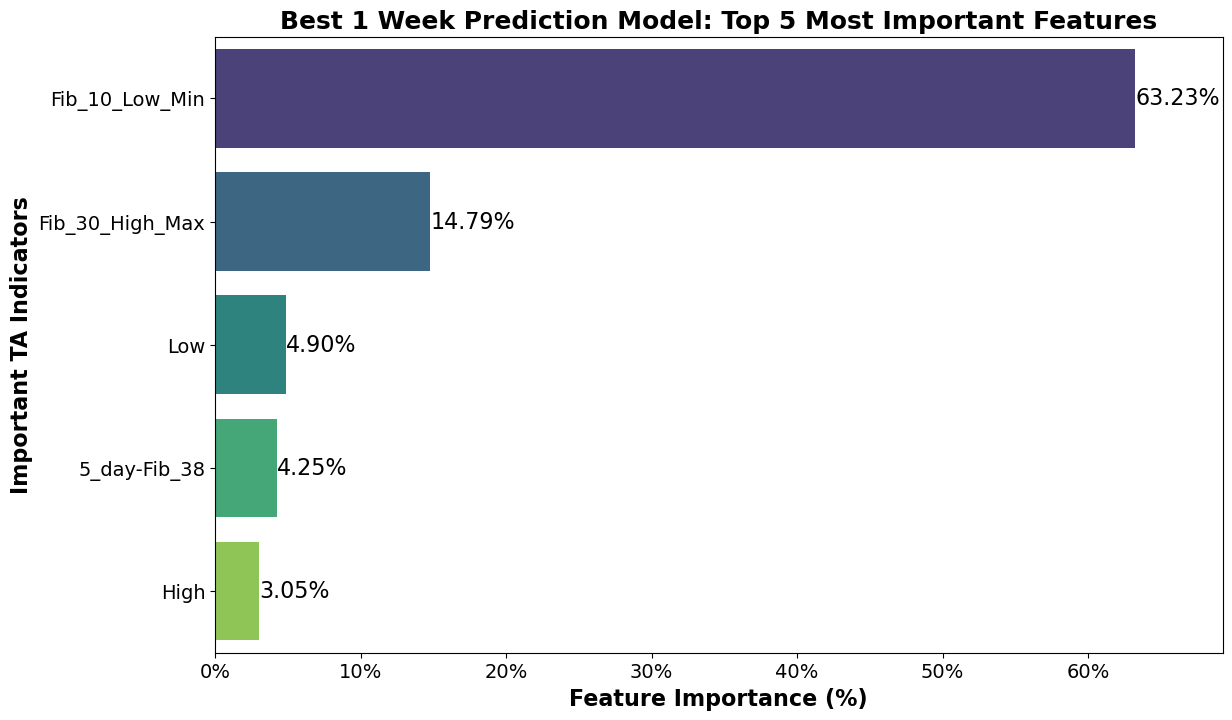

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Week Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()
